# Stanford CME 241: Assignment 2

## Question 1

The state space for the *Snakes and Ladders* game are the tiles numbered 1 to 100 that are **not** at the bottom of a ladder or the top of a chute, plus "tile 0" where the game begins. Tile number 100 is the terminal state. 

The transition table is a map from every state to six other states, each occuring with probability 1/6. For example, the transition table entry for tile 0 looks like:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-f8tv{border-color:inherit;font-style:italic;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-fymr">From</th>
    <th class="tg-7btt" colspan="6">To</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-fymr"></td>
    <td class="tg-0pky">38</td>
    <td class="tg-0pky">2</td>
    <td class="tg-0pky">3</td>
    <td class="tg-0pky">14</td>
    <td class="tg-0pky">5</td>
    <td class="tg-0pky">6</td>
  </tr>
  <tr>
    <td class="tg-0pky">0</td>
    <td class="tg-f8tv">1/6</td>
    <td class="tg-f8tv">1/6</td>
    <td class="tg-f8tv">1/6</td>
    <td class="tg-f8tv">1/6</td>
    <td class="tg-f8tv">1/6</td>
    <td class="tg-f8tv">1/6</td>
  </tr>
  <tr>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
</tbody>
</table>

## Question 2

In [1]:
import matplotlib.pyplot as plt

from rl.markov_process import FiniteMarkovProcess
from rl.distribution import Choose, Constant

In [2]:
ladders = {
    1: 38, 
    4: 14, 
    9: 31,
    28: 84,
    21: 42,
    36: 44,
    51: 67,
    71: 91,
    80: 100
}
snakes = {
    16: 6,
    47: 26,
    49: 11,
    56: 53,
    62: 19,
    64: 60,
    87: 24,
    93: 73,
    95: 75,
    98: 78
}

snakes_and_ladders = {**snakes, **ladders}

In [3]:
# Implements what was described in question 1
non_terminal_states = [x for x in range(100) if x not in snakes_and_ladders]

# Mark 100 as the terminal state
transitions = {100: None}
for _from in non_terminal_states:
    _to = []
    for step in range(1, 7):
        rolled_tile = _from + step
        next_tile = snakes_and_ladders.get(rolled_tile, rolled_tile)
        # Step back if we rolled over 100
        if next_tile > 100:
            rolled_tile = 100 - (next_tile - 100)
            next_tile = snakes_and_ladders.get(rolled_tile, rolled_tile)
        _to.append(next_tile)
    # map a tile to a distribution
    transitions[_from] = Choose(_to)
    
process = FiniteMarkovProcess(transitions)

In [4]:
# Store number of time steps for 10_000 different simulations
time_steps = [len(list(process.simulate(Constant(0)))) for _ in range(10_000)]

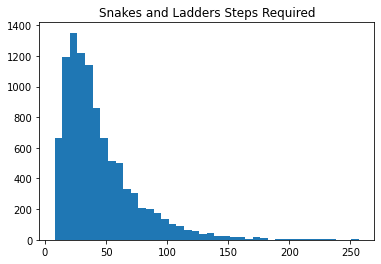

In [5]:
histogram = plt.hist(time_steps, bins=40)
plt.title("Snakes and Ladders Steps Required")
plt.show()

## Question 3

We can solve the **Frog Problem** with a backwards dynamic programming approach.

In [6]:
def frog_problem(n: int) -> float:
    """Solve the Frog Problem.
    
    Compute the expected number of hops the frog will
    take to cross the bank given there are n - 1 lilies 
    between the frog and the opposite bank.
    """
    dp = {}
    for i in reversed(range(n)):
        dp[i] = (1 + sum(1 + dp[j] for j in range(i + 1, n))) / (n - i)
    return dp[0]

In [7]:
frog_problem(10)

2.9289682539682538

## Question 4

In [8]:
from rl.markov_process import FiniteMarkovRewardProcess

To model snakes and ladders as an **MRP**, we can assign a reward of +1 to every tile and use a gamma of +1. The value function will then represent how many more rolls are expected at each tile.

In [9]:
reward_transition_map = {}
for s, distro in transitions.items():
    # Add a reward of 1 to the distribution
    reward_transition_map[s] = Choose({(n, 1) for n in distro.options}) if distro else None

In [10]:
mrp = FiniteMarkovRewardProcess(reward_transition_map)

In [11]:
mrp.get_value_function_vec(1)[0]

41.06185861530892

From tile 0, we can expect about 41 rolls to complete the game, which looks reasonable when compared to the histogram from question two.

## Question 5

In [12]:
from dataclasses import dataclass
from typing import Callable, Tuple

from rl.markov_process import MarkovRewardProcess
from rl.distribution import Categorical
from rl.gen_utils.common_funcs import get_logistic_func

In [13]:
@dataclass(frozen=True)
class State:
    stock_price: int
        
@dataclass
class StockMRP(MarkovRewardProcess[State]):
    """
    This MRP models a stock with mean-reverting behavior described
    by a logistic functions (MP1 in the book). At every transition step,
    the stock price either increases, or decreases, by 1.
    """
    
    level_param: int
    reward_func: Callable[[State], float]
    alpha: float = 0.25
    
    def transition_reward(self, state: State) -> Categorical[Tuple[State, float]]:
        """Given a state, return a distribution of the next state and reward."""
        up_prob: float = get_logistic_func(self.alpha)(self.level_param - state.stock_price)
        
        up_state: State = State(state.stock_price + 1)
        down_state: State = State(state.stock_price - 1)
            
        reward: float = self.reward_func(state)
        return Categorical({
            (up_state, self.reward_func(up_state)): up_prob,
            (down_state, self.reward_func(down_state)): 1 - up_prob
        })

In [14]:
# Our reward function describes a scenario where we got long 
# the stock at a price of 90
payoff = lambda state: state.stock_price - 90

mrp = StockMRP(level_param=100, reward_func=payoff)

In [15]:
mrp.transition_reward(State(110))

{(State(stock_price=111), 21): 0.07585818002124355, (State(stock_price=109), 19): 0.9241418199787564}